# Feature Extraction with PCA & SVD

**Table of Contents**
<div id="toc"></div>

## Preparation

In [28]:
import ConfigParser
config = ConfigParser.ConfigParser()
config.read('config.ini')

import pandas as pd
import numpy as np
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

if config.getboolean('Booleans', 'UseLessFeatures') == True:
    csvFileName = 'gtd_processed_5features.csv'
else:
    csvFileName = 'gtd_processed_11features.csv'
    
gtd = pd.read_csv(csvFileName, encoding='latin1', low_memory=False)

In [29]:
gtd.tail(5)

,gname,iyear,country,crit1,crit2,crit3,attacktype1,targtype1,targsubtype1,weaptype1,weapsubtype1,ransom
88652,Taliban,2016,4,1,1,0,9,4,27.0,13,0.0,0.0
88653,Taliban,2016,4,1,1,1,3,17,94.0,6,16.0,0.0
88654,Boko Haram,2016,146,1,1,0,9,4,34.0,13,0.0,0.0
88655,Lord's Resistance Army (LRA),2016,229,1,1,1,6,14,75.0,13,0.0,0.0
88656,Sudan Liberation Movement,2016,195,1,1,1,2,14,75.0,5,5.0,0.0


In [30]:
features = gtd[['iyear', 'country', 'crit1', 'crit2', 'crit3', 'attacktype1', 'targtype1', 
                'targsubtype1', 'weaptype1', 'weapsubtype1', 'ransom']]

In [31]:
df = (pd.DataFrame(features)).to_dict(orient='records')
dv = DictVectorizer(sparse=False) 
features = dv.fit_transform(features.to_dict(orient='records'))

In [32]:
array = gtd.values
X = array[:,1:]
target = array[:,0]

## PCA

In [33]:
pca = PCA(n_components=11)
reducedPCAFeatures = pca.fit_transform(features)

### Variance

In [34]:
print pca.explained_variance_

[  1.61467776e+04   1.03251998e+03   1.81087665e+02   4.85180902e+01
   9.89689189e+00   7.90014713e+00   1.49396641e+00   7.21598111e-01
   1.17996814e-01   8.46006544e-03   2.78840805e-03]


### Variance Ratio

In [35]:
print pca.explained_variance_ratio_

[  9.26429270e-01   5.92413393e-02   1.03899934e-02   2.78374917e-03
   5.67839016e-04   4.53274808e-04   8.57170537e-05   4.14020448e-05
   6.77012497e-06   4.85400395e-07   1.59986277e-07]


### Variance Ratio Cumulative Sum

In [36]:
print pca.explained_variance_ratio_.cumsum()

[ 0.92642927  0.98567061  0.9960606   0.99884435  0.99941219  0.99986547
  0.99995118  0.99999258  0.99999935  0.99999984  1.        ]


So we would retain 99.6% of the variance with 3 components

### Refit

In [37]:
pca = PCA(n_components=3)
reducedPCAFeatures = pca.fit_transform(features)

Split for PCA:

In [38]:
X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA = train_test_split(reducedPCAFeatures, target, test_size=0.30)

## SVD:

In [39]:
svd = TruncatedSVD(n_components=10)
reducedSVDFeatures = svd.fit_transform(features)

### Variance

In [40]:
print svd.explained_variance_

[  2.19093628e+02   1.61102411e+04   1.03051996e+03   4.89347576e+01
   9.90650539e+00   7.98737115e+00   1.50771007e+00   7.24079714e-01
   1.18768839e-01   8.49153141e-03]


### Variance Ratio

In [41]:
print svd.explained_variance_ratio_

[  1.25706042e-02   9.24332968e-01   5.91265872e-02   2.80765567e-03
   5.68390595e-04   4.58279329e-04   8.65056032e-05   4.15444280e-05
   6.81442025e-06   4.87205771e-07]


### Variance Ratio Cumulative Sum

In [42]:
print svd.explained_variance_ratio_.cumsum()

[ 0.0125706   0.93690357  0.99603016  0.99883781  0.99940621  0.99986448
  0.99995099  0.99999253  0.99999935  0.99999984]


So we would also retain 99.6% of the variance with 3 components

### Refit

In [43]:
svd = TruncatedSVD(n_components=3)
reducedSVDFeatures = svd.fit_transform(features)

Split for SVD:

In [44]:
X_train_SVD, X_test_SVD, Y_train_SVD, Y_test_SVD = train_test_split(reducedSVDFeatures, target, test_size=0.30)

## Classifying

In [45]:
models = []
models.append(('KNC', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))

if config.getboolean('Booleans', 'RunPoorPerformingClassifiers') == True:
    models.append(('GNB', GaussianNB())) # GNB: 0.353792% (0.002758) - 9.339 seconds
    models.append(('LDA', LinearDiscriminantAnalysis())) #LDA: 0.285051% (0.004282) - 5.299 seconds

if config.getboolean('Booleans', 'RunRandomForest') == True:
    models.append(('RF', RandomForestClassifier()))

if config.getboolean('Booleans', 'RunSVM') == True:
    models.append(('SVM', SVC())) #Too slow for this many samples - O(N^3)

results = []
names = []
scoring = 'accuracy'
seed = 188

### PCA

In [46]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train_PCA, Y_train_PCA, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNC: 0.669444% (0.005984) - 5.114 seconds
DTC: 0.690407% (0.005869) - 38.364 seconds


#### Result Plot:

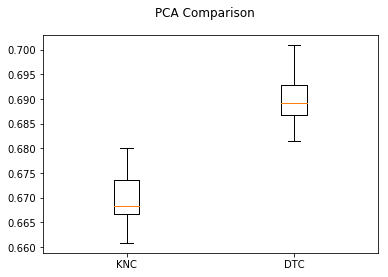

In [47]:
fig = plt.figure()
fig.suptitle('PCA Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Predicting on Validation set

In [48]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
validation_size = 0.10
X_train_PCA, X_validation, Y_train_PCA, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [49]:
cart = DecisionTreeClassifier()
cart.fit(X_train_PCA, Y_train_PCA)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.719377396797
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                                      precision    recall  f1-score   support

                                                                               1 May       0.00      0.00      0.00         1
                                                                          14 K Triad       1.00      1.00      1.00         1
                               16 January Organization for the Liberation of Tripoli       0.50      1.00      0.67         2
                                                                       2 April Group       0.50      1.00      0.67         1
                                                         20 December Movement (M-20)       1.00      1.00      1.00         3
                                                  23rd of September Communist League       0.60     

### SVD

In [50]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train_SVD, Y_train_SVD, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNC: 0.674729% (0.003270) - 5.47 seconds
DTC: 0.695741% (0.006009) - 47.278 seconds


#### Result Plot:

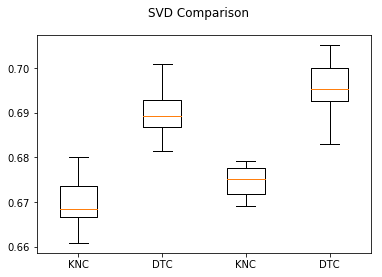

In [51]:
fig = plt.figure()
fig.suptitle('SVD Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Predicting on Validation set

In [52]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
validation_size = 0.10
X_train_SVD, X_validation, Y_train_SVD, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [53]:
cart = DecisionTreeClassifier()
cart.fit(X_train_SVD, Y_train_SVD)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.719828558538
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                               precision    recall  f1-score   support

                                                                        1 May       0.00      0.00      0.00         1
                                                                   14 K Triad       1.00      1.00      1.00         1
                        16 January Organization for the Liberation of Tripoli       0.50      1.00      0.67         2
                                                                2 April Group       0.50      1.00      0.67         1
                                                  20 December Movement (M-20)       1.00      1.00      1.00         3
                                           23rd of September Communist League       0.60      0.75      0.67         4
                       